In [81]:
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve


# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import AdaBoostClassifier

## Data Exploration and Pre-processing


In [82]:
# load data
white_df = pd.read_csv('winequality-white.csv', sep=';')
white_names = list(white_df.columns.values)
pclass = []
for i in range(1, 13):
    pclass.append('pt' + str(i))
bach_df = pd.read_csv('jsbach_chorals_harmony.csv', header=None, sep=',',
          names=['choral_id', 'event_num', 'pt1', 'pt2', 'pt3', 'pt4', 'pt5', 'pt6', 'pt7', 'pt8',
                'pt9', 'pt10', 'pt11', 'pt12', 'bass', 'meter', 'chord_label'],
          dtype={'bass' : 'category',
                 'chord_label' : 'category'})

print(white_df.shape)
print(bach_df.shape)
white_df.dtypes

(4898, 12)
(5665, 17)


fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [83]:
white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [84]:
# bach doesn't have missing data
bach_df.head()
bach_df['choral_id'] = bach_df['choral_id'].str.strip()

In [85]:
# set category type 
for i in range(1, 13):
    cur = 'pt' + str(i)
    bach_df[cur] = bach_df[cur].astype('category')
    
bach_df.dtypes
bach_df.head()

,choral_id,event_num,pt1,pt2,pt3,pt4,pt5,pt6,pt7,pt8,pt9,pt10,pt11,pt12,bass,meter,chord_label
0,000106b_,1,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3,F_M
1,000106b_,2,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,5,C_M
2,000106b_,3,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,2,C_M
3,000106b_,4,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3,F_M
4,000106b_,5,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,2,F_M


In [86]:
bach_df['chord_root'] = bach_df['chord_label'].str[1]
bach_df = bach_df.drop(columns=['chord_label'])
bach_df.chord_root.value_counts()
# drop chord label

C    869
D    843
F    821
B    807
E    785
G    779
A    761
Name: chord_root, dtype: int64

In [87]:
# encode category data type
category_vars = ['choral_id'] + pclass + ['bass', 'chord_root']
cate_les = []
#print(category_vars)
for cur in category_vars:
    le = LabelEncoder()
    le.fit(bach_df[cur])
    bach_df[cur] = le.transform(bach_df[cur])
    cate_les.append(le)

bach_df.head()


,choral_id,event_num,pt1,pt2,pt3,pt4,pt5,pt6,pt7,pt8,pt9,pt10,pt11,pt12,bass,meter,chord_root
0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,12,3,5
1,0,2,1,0,0,0,1,0,0,1,0,0,0,0,10,5,2
2,0,3,1,0,0,0,1,0,0,1,0,0,0,0,10,2,2
3,0,4,1,0,0,0,0,1,0,0,0,1,0,0,12,3,5
4,0,5,1,0,0,0,0,1,0,0,0,1,0,0,12,2,5


In [88]:
# normalize wine labels

white_df['quality'] = white_df['quality'] - 3
white_df.quality.value_counts()

3    2198
2    1457
4     880
5     175
1     163
0      20
6       5
Name: quality, dtype: int64

(array([761., 807.,   0., 869.,   0., 843., 785.,   0., 821., 779.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

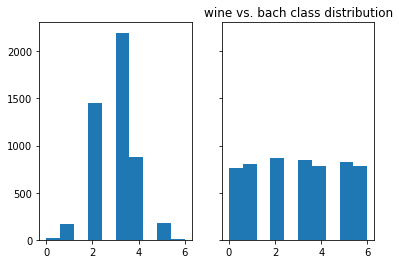

In [89]:
fig, axs = plt.subplots(1, 2, sharey=True)
plt.title("wine vs. bach class distribution")
axs[0].hist(white_df.quality)
axs[1].hist(bach_df.chord_root)


In [90]:
bach_df.chord_root.value_counts()

2    869
3    843
5    821
1    807
4    785
6    779
0    761
Name: chord_root, dtype: int64

In [91]:
# Prepare training data x and y
white_X = white_df.values[:,0:-1]
white_Y = white_df.values[:,-1]
# print(white_X.shape)
# print(white_Y.shape)
# print(white_X)
# print(white_Y)
bach_X = bach_df.values[:, 0:-1] 
bach_Y = bach_df.values[:, -1]
# print(bach_X)
# print(b)
print(np.unique(white_Y, return_counts=True))
print(np.unique(bach_Y, return_counts=True))



(array([0., 1., 2., 3., 4., 5., 6.]), array([  20,  163, 1457, 2198,  880,  175,    5]))
(array([0, 1, 2, 3, 4, 5, 6]), array([761, 807, 869, 843, 785, 821, 779]))


# 1. Clustering

In [92]:
from sklearn import metrics, decomposition
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.ticker import MaxNLocator
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D

In [265]:
class KMeansTestCluster():
    def __init__(self, title, X, y, clusters, plot=True, targetcluster=7, stats=False):
        self.X = X
        self.y = y
        self.clusters = clusters
        self.gen_plot = plot
        self.targetcluster = targetcluster
        self.stats = stats
        self.title = title

    def run(self):
        meandist=[]
        homogeneity_scores=[]
        completeness_scores=[]
        v_measure = []
        rand_scores=[]
        silhouettes=[]

        for k in self.clusters:
            model = KMeans(n_clusters=k, max_iter=500, init='k-means++')
            labels = model.fit_predict(self.X)

            if k == self.targetcluster and self.stats:
                #print labels
                nd_data = np.concatenate((self.X, np.expand_dims(labels, axis=1),np.expand_dims(self.y, axis=1)), axis=1)
                pd_data = pd.DataFrame(nd_data)
                pd_data.to_csv("cluster_kmeans.csv", index=False, index_label=False, header=False)
                #print model.cluster_centers_
                print cdist(self.X, model.cluster_centers_, 'euclidean').shape

            min = np.min(np.square(cdist(self.X, model.cluster_centers_, 'euclidean')), axis = 1)
            print "###"
            print -model.score(self.X)/self.X.shape[0]
            #print min
            value = np.mean(min)
            meandist.append(value)

            homogeneity_scores.append(metrics.homogeneity_score(self.y, labels))
            completeness_scores.append(metrics.completeness_score(self.y, labels))
            rand_scores.append(metrics.adjusted_rand_score(self.y, labels))
        print meandist
        if self.gen_plot:
            #self.visualize()

            self.plot(meandist, homogeneity_scores, completeness_scores, rand_scores, silhouettes)
        return homogeneity_scores

    def visualize(self):
        """
        Generate scatter plot of Kmeans with Centroids shown
        """
        fig = plt.figure(1)
        plt.clf()
        plt.cla()

        X_new = decomposition.pca.PCA(n_components=3).fit_transform(self.X)
        model = KMeans(n_clusters=self.targetcluster, max_iter=5000, init='k-means++')
        labels = model.fit_predict(X_new)
        totz = np.concatenate((X_new,  np.expand_dims(labels, axis=1), np.expand_dims(self.y, axis=1),), axis=1)

        # for each cluster
        colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'black', 'beige', 'banana']
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for clust in range(0, self.targetcluster):
            totz_clust = totz[totz[:,-2] == clust]
            print "Cluster Size"
            print totz_clust.shape

            benign = totz_clust[totz_clust[:,-1] == 1]
            malignant = totz_clust[totz_clust[:,-1] == 0]

            ax.scatter(benign[:, 0], benign[:, 1], benign[:, 2], color=colors[clust], marker=".")
            ax.scatter(malignant[:, 0], malignant[:, 1], malignant[:, 2], color=colors[clust], marker="x")

        centroids = model.cluster_centers_
        ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
            marker='x', s=169, linewidths=3, color="black",
             zorder=10)

        # ax.title("Breast Cancer Clustering")
        ax.set_xlabel("1st Component")
        ax.set_ylabel("2nd Component")
        ax.set_zlabel("3rd Component")
        plt.show()

    def plot(self, meandist, homogeneity, completeness, rand, silhouettes):
            """
            Plot average distance from observations from the cluster centroid
            to use the Elbow Method to identify number of clusters to choose
            """
            ax = plt.figure().gca()
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.plot(self.clusters, meandist)
            plt.xlabel('Number of clusters')
            plt.ylabel('Average within cluster SSE')
            plt.title(self.title + '-Kmeans-Average within cluster SSE')
            #plt.show()

            #plt.clf()

            """
            Plot homogeneity from observations from the cluster centroid
            to use the Elbow Method to identify number of clusters to choose
            """
            ax = plt.figure().gca()
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.plot(self.clusters, homogeneity)
            plt.xlabel('Number of clusters')
            plt.ylabel('Homogeneity Score')
            plt.title(self.title + '-Kmeans-Homogeneity Score')
            #plt.show()

            #plt.clf()

            """
                       Plot completeness from observations from the cluster centroid
                       to use the Elbow Method to identify number of clusters to choose
                       """
            ax = plt.figure().gca()
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.plot(self.clusters, completeness)
            plt.xlabel('Number of clusters')
            plt.ylabel('Completeness Score')
            plt.title(self.title + '-Kmeans-Completeness Score')
            plt.show()

            #plt.clf()

           

In [266]:
class ExpectationMaximizationTestCluster():
    def __init__(self, title, X, y, clusters, plot=False, targetcluster=3, stats=False):
        self.X = X
        self.y = y
        self.clusters = clusters
        self.gen_plot = plot
        self.targetcluster = targetcluster
        self.stats = stats
        self.title = title

    def run(self):
        ll=[]
        homogeneity_scores=[]
        completeness_scores=[]
        rand_scores=[]
        silhouettes=[]
        bic=[]
        aic=[]
        model = GMM(covariance_type = 'diag')

        for k in self.clusters:
            model.set_params(n_components=k)
            model.fit(self.X)
            labels = model.predict(self.X)
            #print labels
            if k == self.targetcluster and self.stats:
                nd_data = np.concatenate((self.X, np.expand_dims(labels, axis=1),np.expand_dims(self.y, axis=1)), axis=1)
                pd_data = pd.DataFrame(nd_data)
                pd_data.to_csv("cluster_em.csv", index=False, index_label=False, header=False)

                for i in range (0,self.targetcluster):
                    #print "Cluster {}".format(i)
                    cluster = pd_data.loc[pd_data.iloc[:,-2]==i].iloc[:,-2:]
                    print cluster.shape[0]
                    #print float(cluster.loc[cluster.iloc[:,-1]==0].shape[0])/cluster.shape[0]
                    #print float(cluster.loc[cluster.iloc[:,-1]==1].shape[0])/cluster.shape[0]

           
            ll.append(model.score(self.X))
            print model.score(self.X)
            homogeneity_scores.append(metrics.homogeneity_score(self.y, labels))
            completeness_scores.append(metrics.completeness_score(self.y, labels))
            rand_scores.append(metrics.adjusted_rand_score(self.y, labels))
            bic.append(model.bic(self.X))
            aic.append(model.aic(self.X))
            #silhouettes.append(metrics.silhouette_score(self.X, model.labels_ , metric='euclidean',sample_size=self.X.shape[0]))

        if self.gen_plot:
            #self.visualize()
            self.plot(ll, homogeneity_scores, completeness_scores, rand_scores, bic, aic)
        return homogeneity_scores

    def visualize(self):
        """
        Generate scatter plot of EM with Centroids shown
        """
        fig = plt.figure(1)
        plt.clf()
        plt.cla()

        X_new = decomposition.pca.PCA(n_components=3).fit_transform(self.X)
        model = GMM(n_components=self.targetcluster, covariance_type='full')
        labels = model.fit_predict(X_new)
        totz = np.concatenate((X_new,  np.expand_dims(labels, axis=1), np.expand_dims(self.y, axis=1),), axis=1)

        # for each cluster
        colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'black', 'beige', 'banana']
        fig = plt.figure()

        for clust in range(0, self.targetcluster):
            totz_clust = totz[totz[:,-2] == clust]
            print "Cluster Size"
            print totz_clust.shape

            benign = totz_clust[totz_clust[:,-1] == 1]
            malignant = totz_clust[totz_clust[:,-1] == 0]

            plt.scatter(benign[:, 0], benign[:, 1],  color=colors[clust], marker=".")
            plt.scatter(malignant[:, 0], malignant[:, 1],  color=colors[clust], marker="x")

        # centroids = model.
        # plt.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
        #     marker='x', s=169, linewidths=3, color="black",
        #      zorder=10)

        plt.xlabel("1st Component")
        plt.ylabel("2nd Component")
        plt.show()

    def plot(self, ll, homogeneity, completeness, rand, bic, aic):
            # """
            # Plot average distance from observations from the cluster centroid
            # to use the Elbow Method to identify number of clusters to choose
            # """
            # plt.plot(self.clusters, meandist)
            # plt.xlabel('Number of clusters')
            # plt.ylabel('Average distance')
            # plt.title('Average distance vs. K Clusters')
            # plt.show()
            #
            # plt.clf()

            ax = plt.figure().gca()
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.plot(self.clusters, ll)
            plt.xlabel('Number of clusters')
            plt.ylabel('Log Probablility')
            plt.title(self.title + '-EM-Log Probability')
            #plt.show()

            #plt.clf()

            """
            Plot homogeneity from observations from the cluster centroid
            to use the Elbow Method to identify number of clusters to choose
            """
            ax = plt.figure().gca()
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.plot(self.clusters, homogeneity)
            plt.xlabel('Number of clusters')
            plt.ylabel('Homogeneity Score')
            plt.title(self.title + '-EM-Homogeneity Score')
            #plt.show()

            #plt.clf()


            """
            Plot completeness from observations from the cluster centroid
            to use the Elbow Method to identify number of clusters to choose
            """
            ax = plt.figure().gca()
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.plot(self.clusters, completeness)
            plt.xlabel('Number of clusters')
            plt.ylabel('Completeness Score')
            plt.title(self.title + '-EM-Completeness Score')
            #plt.show()

            #plt.clf()


            """
            Plot Adjusted RAND Score from observations from the cluster centroid
            to use the Elbow Method to identify number of clusters to choose

            plt.plot(self.clusters, rand)
            plt.xlabel('Number of clusters')
            plt.ylabel('Adjusted RAND Score')
            plt.title('RAND Score vs. K Clusters')
            plt.show()
            """
            """
            Plot BIC Score from observations from the cluster centroid
            to use the Elbow Method to identify number of clusters to choose
            """
            ax = plt.figure().gca()
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.plot(self.clusters, bic)
            plt.xlabel('Number of clusters')
            plt.ylabel('BIC Score')
            plt.title(self.title + '-EM-BIC Score')
            #plt.show()

            """
            Plot AIC Score from observations from the cluster centroid
            to use the Elbow Method to identify number of clusters to choose
            """
            ax = plt.figure().gca()
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.plot(self.clusters, aic)
            plt.xlabel('Number of clusters')
            plt.ylabel('AIC Score')
            plt.title(self.title + '-EM-AIC Score')
            plt.show()

###
2122.9081271075383
###
850.5790875762832
###
560.418637681139
###
424.9048892985977
###
357.17267265504836
###
315.36919802423637
(4898, 7)
###
280.84682770272815
###
256.2370249514102
###
232.59403259133506
[2122.9081271075397, 850.5790875762845, 560.4186376811417, 424.90488929859754, 357.1726726550474, 315.3691980242356, 280.84682770272843, 256.2370249514096, 232.59403259133518]


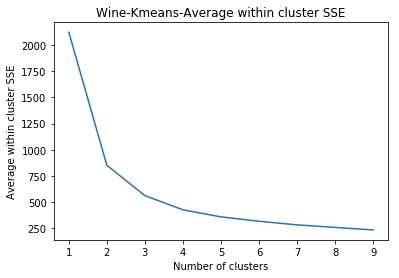

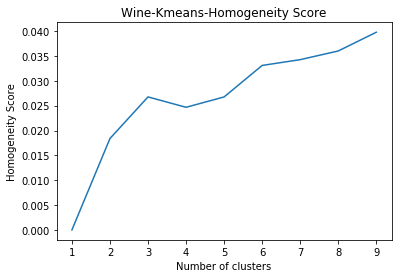

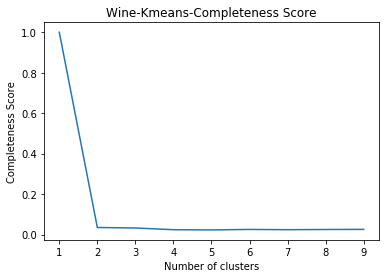

In [95]:
# Run Kmeans on wine dataset
wine_kmeans = KMeansTestCluster("Wine", white_X, white_Y, clusters=range(1,10), plot=True, stats=True)
wine_kmeans.run()

###
1697.8623194247202
###
791.513153824803
###
540.8219901962134
###
423.81798015288757
###
341.33589220689504
###
273.1923041548346
(5665, 7)
###
236.7672342808969
###
208.09626171615687
###
189.6380173599047
[1697.862319424721, 791.5131538248044, 540.821990196214, 423.8179801528892, 341.3358922068953, 273.1923041548342, 236.76723428089713, 208.09626171615696, 189.63801735990432]


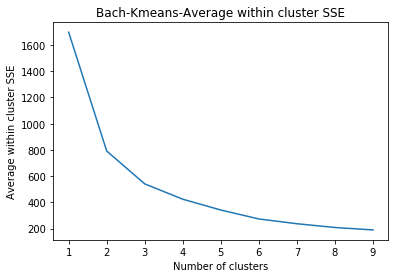

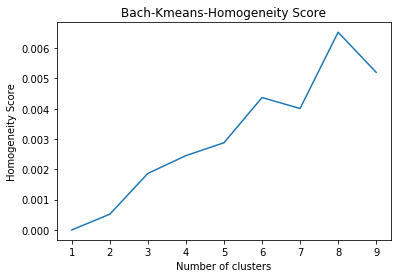

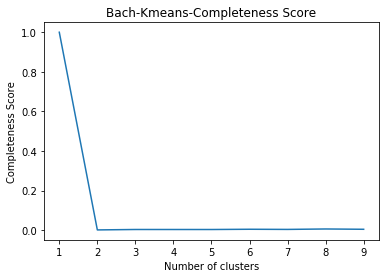

In [96]:
# run kmeans on bach dataset
bach_kmeans = KMeansTestCluster("Bach", bach_X, bach_Y, clusters=range(1,10), plot=True, stats=True)
bach_kmeans.run()

-5.751288480046831
-4.385517722984199
1732
2739
427
-3.851620983327516
-3.512252746447308
-3.2193467100931383
-3.308262174241131
-3.041701830941017
-2.9759669234392336
-2.806814431186702


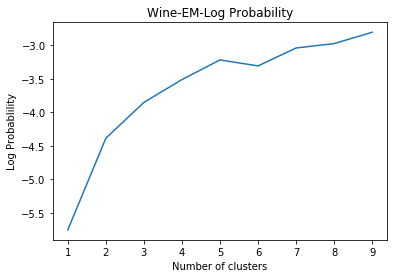

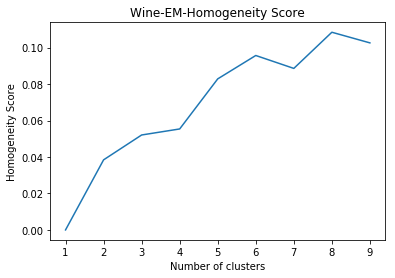

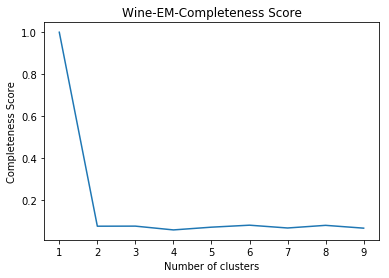

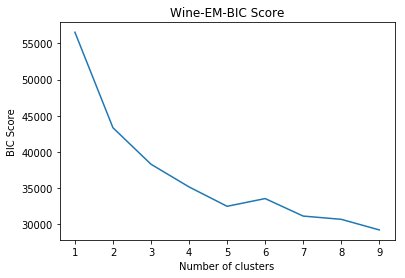

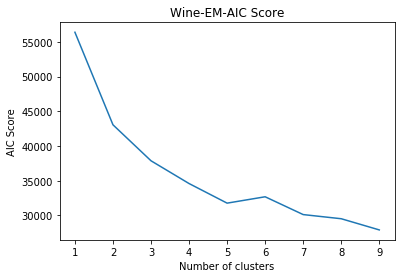

In [97]:
# Wine EM 
wine_em = ExpectationMaximizationTestCluster("Wine", white_X, white_Y, clusters=range(1,10), plot=True, stats=True)
wine_em.run()

-20.50613172803177
-14.292137941933031
2267
265
3133
-8.515431119133897
-6.1578571327869325
-4.822476339263553
-0.4831455611721593
-1.4930169153136328
4.1477514951539645
6.360427595504339


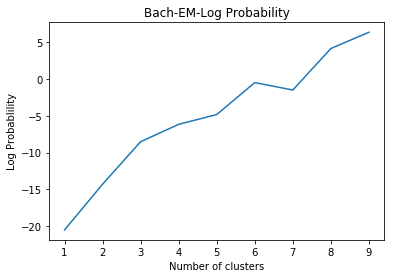

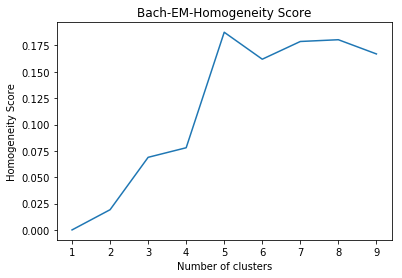

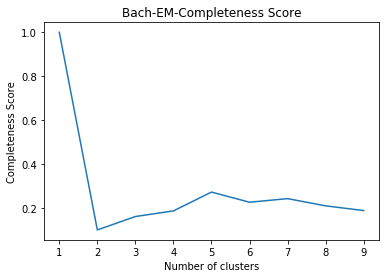

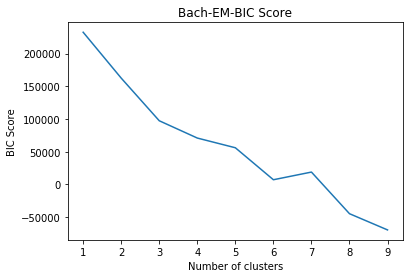

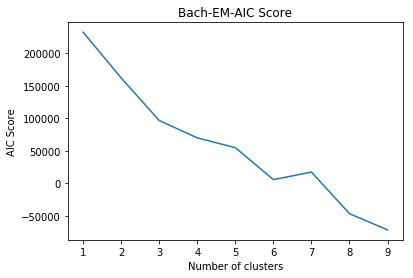

In [98]:
# Bach EM
bach_em = ExpectationMaximizationTestCluster("Bach", bach_X, bach_Y, clusters=range(1,10), plot=True, stats=True)
bach_em.run()

Cluster Size
(1192, 5)
Cluster Size
(640, 5)
Cluster Size
(425, 5)
Cluster Size
(664, 5)
Cluster Size
(312, 5)
Cluster Size
(616, 5)
Cluster Size
(1049, 5)


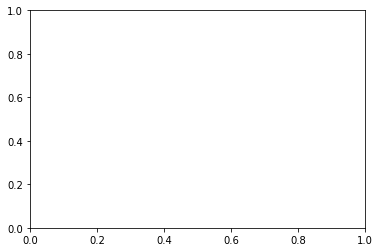

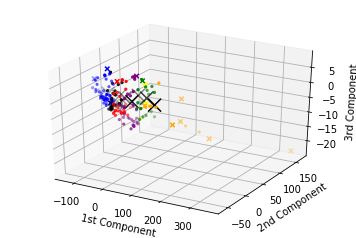

In [99]:
wine_kmeans.visualize()

AttributeError: 'GaussianMixture' object has no attribute 'fit_predict'

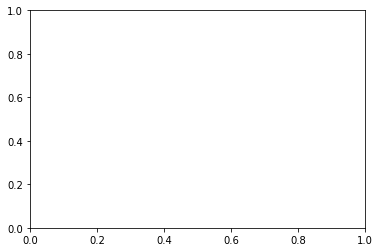

In [100]:
wine_em.visualize()

Cluster Size
(868, 5)
Cluster Size
(324, 5)
Cluster Size
(741, 5)
Cluster Size
(937, 5)
Cluster Size
(1017, 5)
Cluster Size
(1065, 5)
Cluster Size
(713, 5)


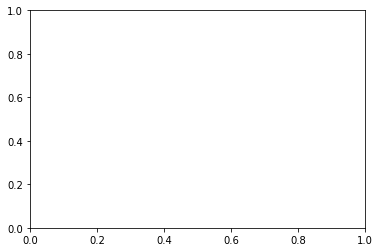

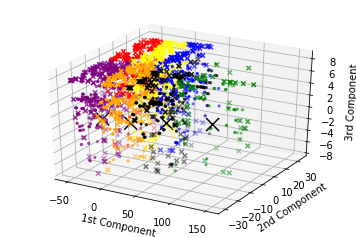

In [101]:
bach_kmeans.visualize()

AttributeError: 'GaussianMixture' object has no attribute 'fit_predict'

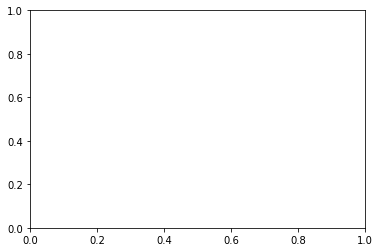

In [102]:
bach_em.visualize()

# Dimensionality Reduction + Clustering

In [164]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.decomposition import TruncatedSVD

from itertools import product
from matplotlib import cm
from sklearn.pipeline import Pipeline
from collections import defaultdict
np.set_printoptions(suppress=True)

In [167]:
def plot_barchart(y, xLabel, yLabel, title):
    plt.figure()
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.grid()
    x = range(1, len(y) + 1)
    plt.bar(x, y)
    return plt

def plot_single_line(x, y, xLabel, yLabel, title):
    plt.figure()
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.grid()
    plt.plot(x, y)
    return plt

def plot_mult_line(x, ys, legends, title, xLabel, yLabel):
    plt.figure()
    plt.title(title)

    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    
    plt.grid()

    colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y']
    for i in range(len(ys)):
        val = ys[i]
        label = legends[i]
        color = colors[i]

        plt.plot(x, val, 'o-', color=color,
             label=label)

    plt.legend(loc="best")
    return plt

def reconstruction_error(x, reducer, ncomponent):
    # 4 trials
    recon_errors = np.zeros(ncomponent - 1)
    for nc in range(1, ncomponent):
        reducer.set_params(n_components=nc)
        reduced_X = reducer.fit_transform(x)
        recon = reducer.inverse_transform(reduced_X)
        error = sum(map(np.linalg.norm, recon - x))
        recon_errors[nc - 1] = error
    return recon_errors

def reconstruction_error2(x, reducer, ncomponent):
    # 4 trials
    recon_errors = np.zeros(ncomponent - 1)
    for nc in range(1, ncomponent):
        reducer.set_params(n_components=nc)
        reduced_X = reducer.fit_transform(x)
        inv = np.linalg.pinv(reducer.components_)
        recon = np.dot(reduced_X, inv.T)
        error = sum(map(np.linalg.norm, recon - x))
        recon_errors[nc - 1] = error
    return recon_errors

eigenvals
[0.9097 0.0793 0.0102 0.0005 0.0003 0.     0.     0.     0.     0.
 0.    ]
singular vals
[3075.4870683   908.24766806  324.93719973   72.53575878   57.98975927
    9.52631264    8.36523613    7.48676004    6.50538985    1.39265611
    0.03938987]
recon errors
[54698.2494729  19838.31636405  5778.30405069  3430.65678529
  1015.91395448   791.59413346   595.84437496   349.51720684
    51.54711579     1.73743174     0.        ]


<module 'matplotlib.pyplot' from '/home/ivyivylynn/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

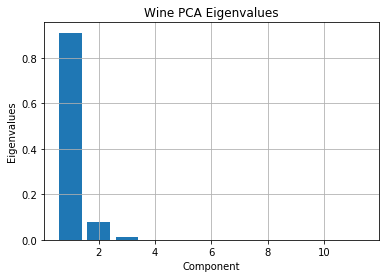

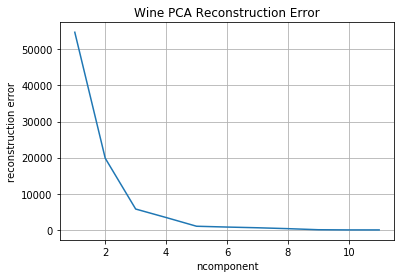

In [157]:
# PCA Wine Quality
# wine has 11 features and bach has 16
pca_wine = PCA()
pca_wine.fit(white_X)
print("eigenvals")
print(pca_wine.explained_variance_ratio_.round(4))
print("singular vals")
print(pca_wine.singular_values_)
plot_barchart(pca_wine.explained_variance_ratio_, "Component", "Eigenvalues", "Wine PCA Eigenvalues")

print("recon errors")
recon_pcaW = reconstruction_error(white_X, pca_wine, 12)
print(recon_pcaW)
plot_single_line(range(1, 12), recon_pcaW, "ncomponent", "reconstruction error", "Wine PCA Reconstruction Error")

eigenvalue and singular value
[0.8197 0.1654 0.0129 0.0007 0.0003 0.0002 0.0002 0.0001 0.0001 0.0001
 0.0001 0.0001 0.     0.     0.     0.    ]
[2807.91080376 1261.23093379  352.01728948   83.16499554   49.27339953
   46.94171894   44.90944576   35.83798      34.78778336   33.25991932
   26.49033591   22.42489415   20.99811687   15.72478681   15.36505795
   10.62958258]
reconstruction error
[88654.31653176 26228.51617772 10291.52966726  8355.35027388
  7355.51145735  6401.61540093  5507.11945752  4794.75110754
  4056.51114158  3367.68777277  2722.8594534   2190.99791062
  1652.84190634  1221.40549543   650.37758263     0.        ]


<module 'matplotlib.pyplot' from '/home/ivyivylynn/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

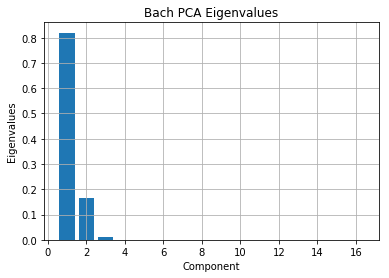

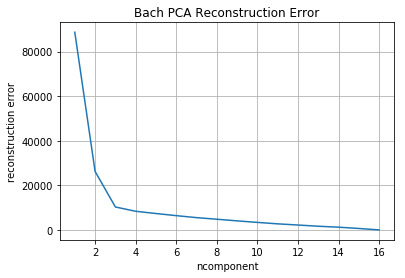

In [158]:
# PCA Bach
pca_bach = PCA()
pca_bach.fit(bach_X)
print("eigenvalue and singular value")
print(pca_bach.explained_variance_ratio_.round(4))
print(pca_bach.singular_values_)
plot_barchart(pca_bach.explained_variance_ratio_, "Component", "Eigenvalues", "Bach PCA Eigenvalues")
print("reconstruction error")
recon_pcaB = reconstruction_error(bach_X, pca_bach, 17)
print(recon_pcaB)
plot_single_line(range(1, 17), recon_pcaB, "ncomponent", "reconstruction error", "Bach PCA Reconstruction Error")

2      4.919680
3      4.210121
4      3.957690
5      3.516456
6      3.016186
7      3.639286
8      3.357064
9      3.854979
10     7.396048
11    63.230756
dtype: float64
Recon Error
[54698.2494729  19838.31636405  5778.30405069  3430.65678529
  1015.91395448   791.59413346   595.84437496   349.51720684
    51.54711579     1.73743174     0.        ]


<module 'matplotlib.pyplot' from '/home/ivyivylynn/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

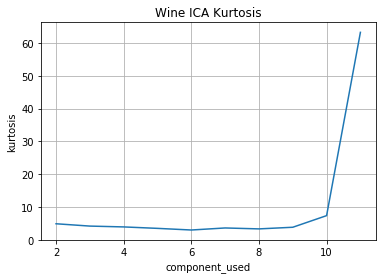

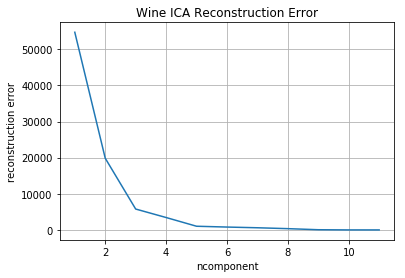

In [159]:
# ICA Wine
kurtosis_wine = {}
ica_wine = FastICA()
for dim in range(2, 12):
    ica_wine.set_params(n_components=dim)
    tmp = ica_wine.fit_transform(white_X)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurtosis_wine[dim] = tmp.abs().mean()

kurt_wine = pd.Series(kurtosis_wine)
print(kurt_wine)
plot_single_line(kurt_wine.index, kurt_wine.values, "component_used", "kurtosis", "Wine ICA Kurtosis")

print("Recon Error")
recon_icaW = reconstruction_error(white_X, ica_wine, 12)
print(recon_icaW)
plot_single_line(range(1, 12), recon_icaW, "ncomponent", "reconstruction error", "Wine ICA Reconstruction Error")

/home/ivyivylynn/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


kurtosis
2     0.972877
3     1.042562
4     1.015771
5     0.986176
6     1.107479
7     1.157065
8     1.124381
9     1.088674
10    1.087505
11    1.239978
12    1.340567
13    1.389505
14    1.409362
15    1.532436
16    1.431166
dtype: float64
Recon Error
[88654.31653176 26228.51617772 10291.52966726  8355.35027385
  7355.51145652  6401.61540093  5507.11945752  4794.75110754
  4056.51114158  3367.68777277  2722.8594534   2190.99791062
  1652.84190634  1221.40549543   650.37758263     0.        ]


<module 'matplotlib.pyplot' from '/home/ivyivylynn/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

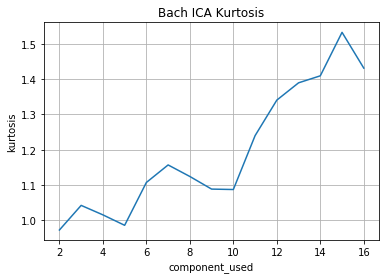

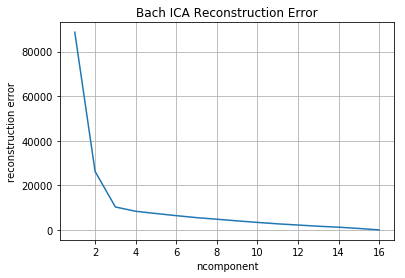

In [160]:
# ICA Bach
kurtosis_bach = {}
ica_bach = FastICA()
for dim in range(2, 17):
    ica_bach.set_params(n_components=dim)
    tmp = ica_bach.fit_transform(bach_X)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurtosis_bach[dim] = tmp.abs().mean()

print("kurtosis")
kurt_bach = pd.Series(kurtosis_bach)
print(kurt_bach)
plot_single_line(kurt_bach.index, kurt_bach.values, "component_used", "kurtosis", "Bach ICA Kurtosis")

print("Recon Error")
recon_icaB = reconstruction_error(bach_X, ica_bach, 17)
print(recon_icaB)
plot_single_line(range(1, 17), recon_icaB, "ncomponent", "reconstruction error", "Bach ICA Reconstruction Error")

Recon Error


<module 'matplotlib.pyplot' from '/home/ivyivylynn/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

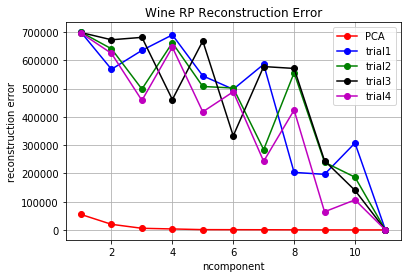

In [247]:
# Random Projection Wine
RP_wine = GaussianRandomProjection()
R_trials = []
print("Recon Error")
legends = ["PCA" ,"trial1", "trial2", "trial3", "trial4"]
R_trials.append(recon_pcaW)
for t in range(4):
    recon_rpW = reconstruction_error2(white_X, RP_wine, 12)
    R_trials.append(recon_rpW)
    
# plot_mult_line(x, ys, legends, title, xLabel, yLabel)
plot_mult_line(range(1, 12), R_trials, legends , "Wine RP Reconstruction Error","ncomponent", "reconstruction error")

Recon Error


<module 'matplotlib.pyplot' from '/home/ivyivylynn/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

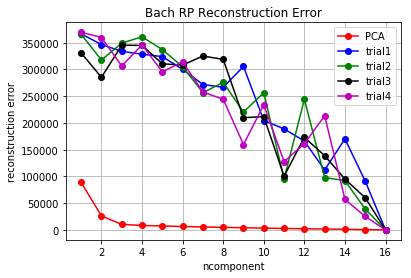

In [248]:
# Randomized Projection Bach
RP_bach = GaussianRandomProjection()
R_trialsB = []
print("Recon Error")
legends = ["PCA" , "trial1", "trial2", "trial3", "trial4"]
R_trialsB.append(recon_pcaB)
for t in range(4):
    recon_rpB = reconstruction_error2(bach_X, RP_bach, 17)
    R_trialsB.append(recon_rpB)
    
# plot_mult_line(x, ys, legends, title, xLabel, yLabel)
plot_mult_line(range(1, 17), R_trialsB, legends , "Bach RP Reconstruction Error","ncomponent", "reconstruction error")

<module 'matplotlib.pyplot' from '/home/ivyivylynn/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

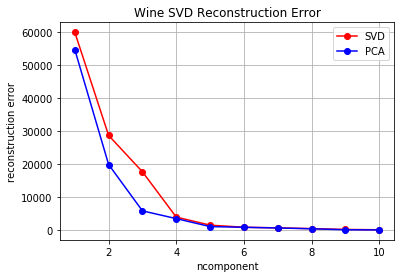

In [256]:
# SVD Wine
svd_wine = TruncatedSVD()
recon_svdW = reconstruction_error(white_X, svd_wine, 11)

plot_mult_line(range(1, 11), [recon_svdW, recon_pcaW[:-1]], ["SVD", "PCA"] , "Wine SVD Reconstruction Error","ncomponent", "reconstruction error")

<module 'matplotlib.pyplot' from '/home/ivyivylynn/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

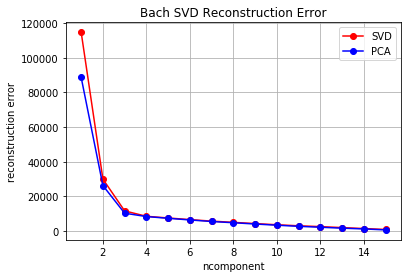

In [258]:
# SVD Bach
svd_bach = TruncatedSVD()
recon_svdB = reconstruction_error(bach_X, svd_bach, 16)
plot_mult_line(range(1, 16), [recon_svdB, recon_pcaB[:-1]], ["SVD", "PCA"] , "Bach SVD Reconstruction Error","ncomponent", "reconstruction error")

# Clustering after Feature Reduction

In [277]:
homo_labels = ["PCA", "ICA", "RP", "SVD"]
homo_kmeansW = []
homo_emW = []
homo_kmeansB = []
homo_emB = []

In [278]:
# PCA
pcaW = PCA(n_components=4)
wine_pcaX = pcaW.fit_transform(white_X)
pcaB5 = PCA(n_components=5)
bach_pcaX5 = pcaB5.fit_transform(bach_X)
pcaB7 = PCA(n_components=7)
bach_pcaX7 = pcaB7.fit_transform(bach_X)

###
2122.168263346132
###
849.8394641650922
###
559.683716426551
###
424.1725856474227
###
356.43366987233736
###
314.66688519793803
(4898, 7)
###
280.1262970131794
###
256.2639824977152
###
231.87660615270215
[2122.1682633461314, 849.8394641650922, 559.6837164265509, 424.17258564742275, 356.43366987233736, 314.66688519793814, 280.12629701317934, 256.26398249771506, 231.8766061527021]


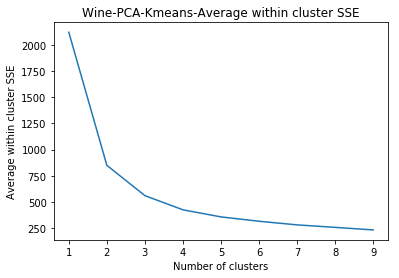

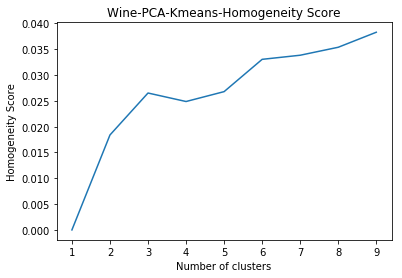

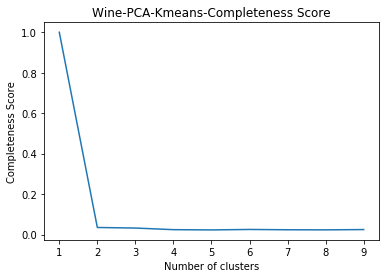

-13.593036922199932
-13.432208550877142
1478
1965
1455
-13.359648939180623
-13.340779345317323
-13.24234248085026
-13.227323621656309
-13.20560360177407
-13.132332459314098
-13.080499759396774


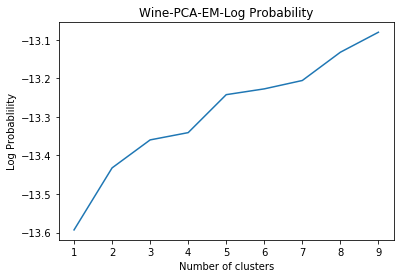

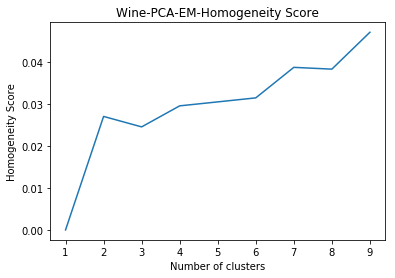

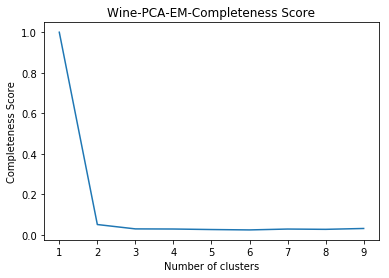

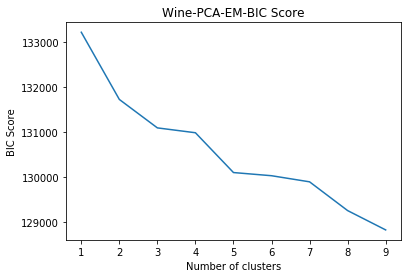

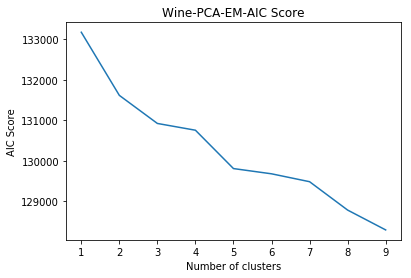

In [279]:
# wine pca
wine_kmeans_pca = KMeansTestCluster("Wine-PCA", wine_pcaX, white_Y, clusters=range(1,10), plot=True, stats=True)
homo_kmeansW.append(wine_kmeans_pca.run())

wine_em_pca = ExpectationMaximizationTestCluster("Wine-PCA", wine_pcaX, white_Y, clusters=range(1,10), plot=True, stats=True)
homo_emW.append(wine_em_pca.run())

###
1696.8309602804054
###
790.4832019139332
###
539.7928162464892
###
422.78772634414514
###
340.30544074889207
###
272.1628714797316
(5665, 7)
###
235.78350750274635
###
207.12997690461106
###
188.6716572428506
[1696.8309602804052, 790.4832019139332, 539.7928162464892, 422.787726344145, 340.30544074889207, 272.1628714797316, 235.78350750274632, 207.12997690461103, 188.6716572428506]


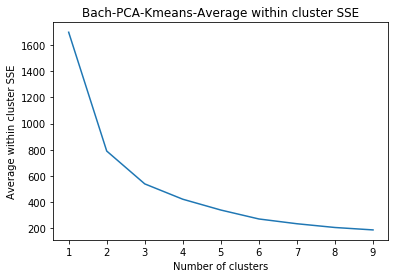

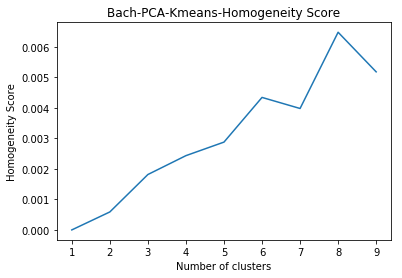

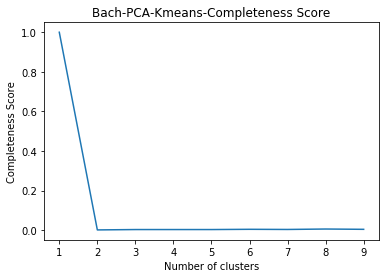

-16.60083773223207
-16.531294084168504
582
2508
2575
-16.49539767277379
-16.455127324535606
-16.440382647137923
-16.426193162967735
-16.40846687500857
-16.410680196608432
-16.40364459190842


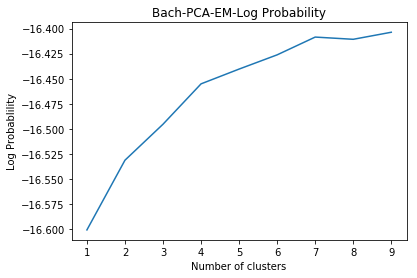

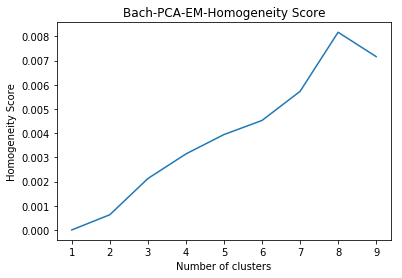

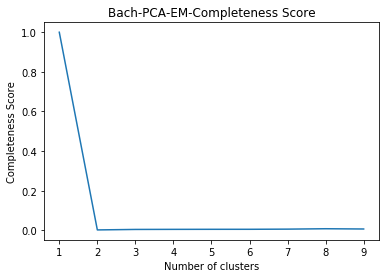

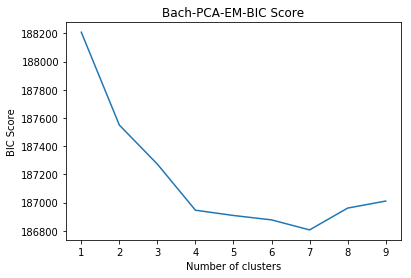

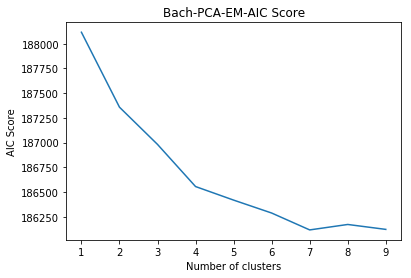

In [280]:
# bach pca
bach_kmeans_pca = KMeansTestCluster("Bach-PCA", bach_pcaX7, bach_Y, clusters=range(1,10), plot=True, stats=True)
homo_kmeansB.append(bach_kmeans_pca.run())

bach_em_pca = ExpectationMaximizationTestCluster("Bach-PCA", bach_pcaX7, bach_Y, clusters=range(1,10), plot=True, stats=True)
homo_emB.append(bach_em_pca.run())

In [281]:
# ICA Data
icaW = FastICA(n_components=5)
icaWX = icaW.fit_transform(white_X)
icaB = FastICA(n_components=5)
icaBX = icaB.fit_transform(bach_X)

###
0.0010208248264597798
###
0.0008676907447843948
###
0.0007486267846612376
###
0.00066308941536699
###
0.0005951407768577643
###
0.0005355741004225596
(4898, 7)
###
0.0005093182530514129
###
0.00048588385032290594
###
0.00046311306898035455
[0.0010208248264597798, 0.0008676907447843948, 0.0007486267846612376, 0.00066308941536699, 0.0005951407768577643, 0.0005355741004225596, 0.0005093182530514128, 0.00048588385032290594, 0.00046311306898035455]


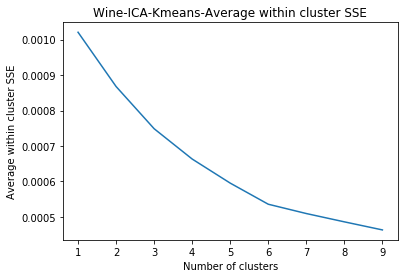

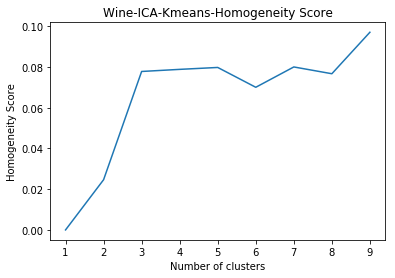

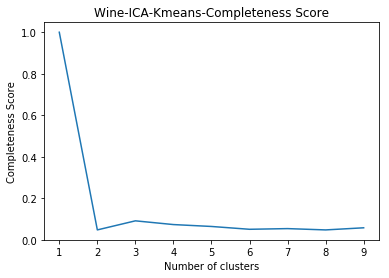

14.146733134520057
14.300495851088556
1915
1508
1475
14.37848777518569
14.395126259131093
14.48529218321714
14.50648762926488
14.531069283034702
14.537260847565761
14.571838035008343


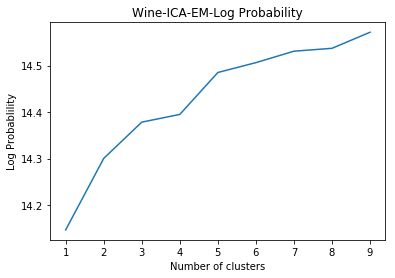

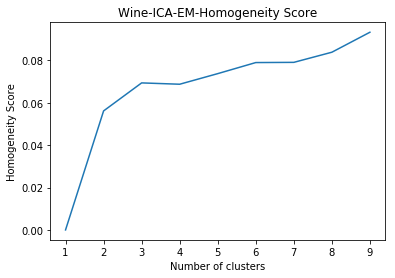

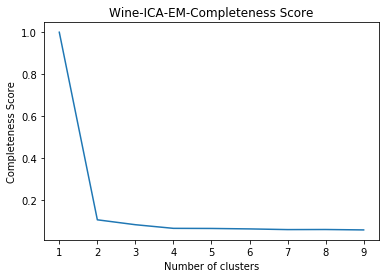

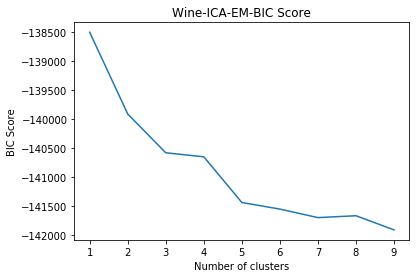

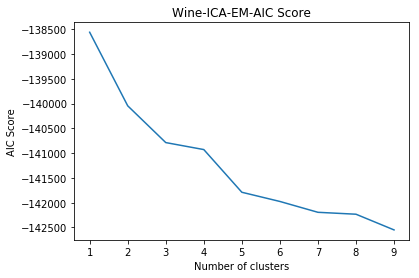

In [282]:
# wine ICA
wine_kmeans_ica = KMeansTestCluster("Wine-ICA", icaWX, white_Y, clusters=range(1,10), plot=True, stats=True)
homo_kmeansW.append(wine_kmeans_ica.run())

wine_em_ica = ExpectationMaximizationTestCluster("Wine-ICA", icaWX, white_Y, clusters=range(1,10), plot=True, stats=True)
homo_emW.append(wine_em_ica.run())

###
0.0008826125330979547
###
0.0007436448423611729
###
0.0006546653887592365
###
0.0005839393496430365
###
0.000526571150550404
###
0.000485405846754263
(5665, 7)
###
0.00044882295789719156
###
0.0004211213906782703
###
0.0003971320041063534
[0.0008826125330979547, 0.0007436448423611729, 0.0006546653887592365, 0.0005839393496430365, 0.000526571150550404, 0.000485405846754263, 0.00044882295789719145, 0.0004211213906782703, 0.0003971320041063534]


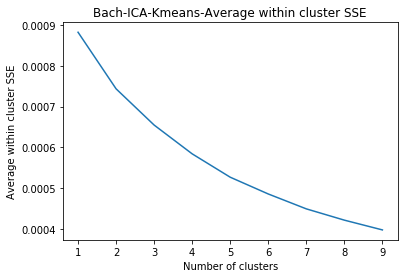

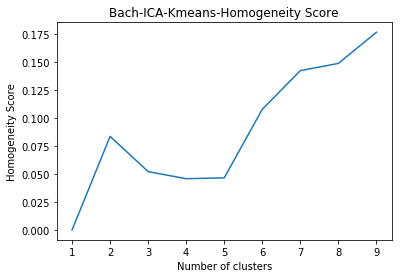

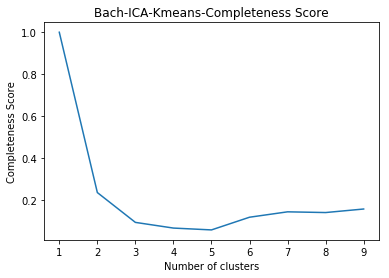

14.510422953435306
14.60222804717999
922
2981
1762
14.665564109430331
14.718352710558008
14.75483848218241
14.900588473235103
14.797532263280825
14.992354520801241
14.836843917433443


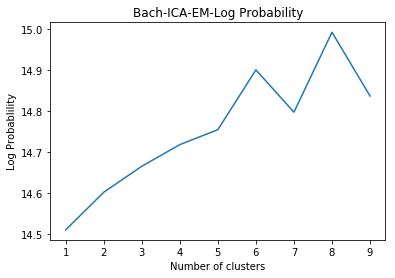

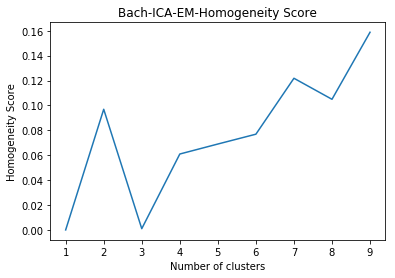

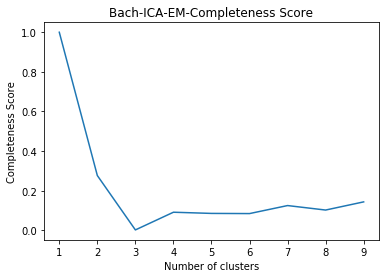

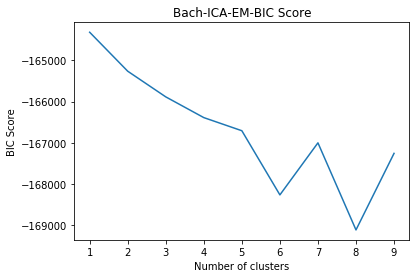

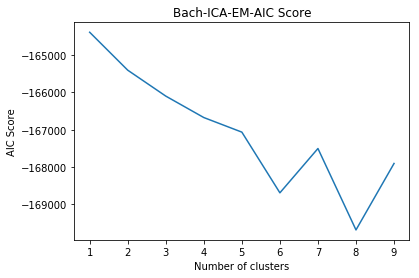

In [283]:
# Bach ICA
bach_kmeans_ica = KMeansTestCluster("Bach-ICA", icaBX, bach_Y, clusters=range(1,10), plot=True, stats=True)
homo_kmeansB.append(bach_kmeans_ica.run())

bach_em_ica = ExpectationMaximizationTestCluster("Bach-ICA", icaBX, bach_Y, clusters=range(1,10), plot=True, stats=True)
homo_emB.append(bach_em_ica.run())

In [284]:
# RP Data
rpW = GaussianRandomProjection(n_components=8)
rpWX = rpW.fit_transform(white_X)
rpB = GaussianRandomProjection(n_components=8)
rpBX = rpB.fit_transform(bach_X)

###
3000.532630855109
###
1115.2129176586416
###
686.2226991695429
###
484.6930781389188
###
386.5332345694887
###
324.2221071717146
(4898, 7)
###
287.6425665375028
###
253.70541806304365
###
231.3238728498612
[3000.532630855107, 1115.2129176586402, 686.2226991695431, 484.69307813891925, 386.53323456948954, 324.22210717171413, 287.6425665375047, 253.70541806304513, 231.3238728498624]


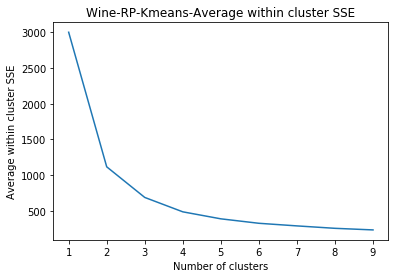

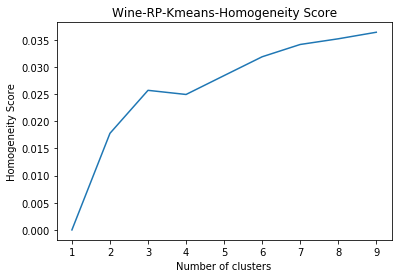

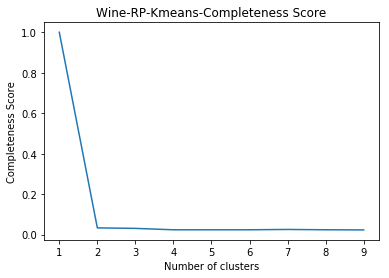

-32.227181030671964
-29.139330213542802
1737
1695
1466
-27.565776446469677
-26.307648237728753
-25.576641639399387
-24.930821090944985
-24.477924341000136
-24.071694513627207
-23.99209176530013


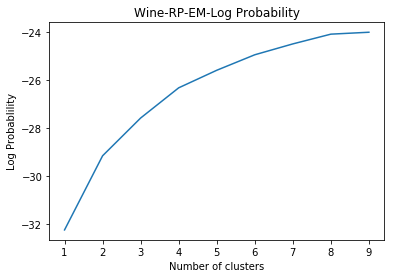

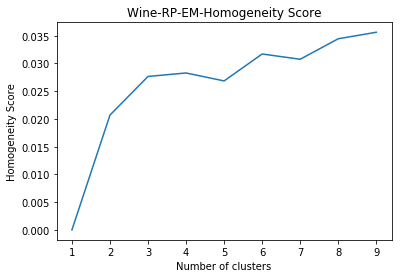

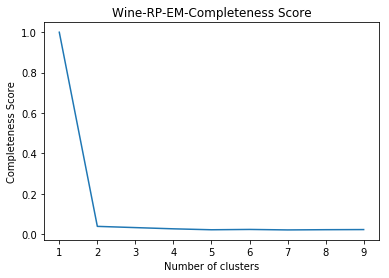

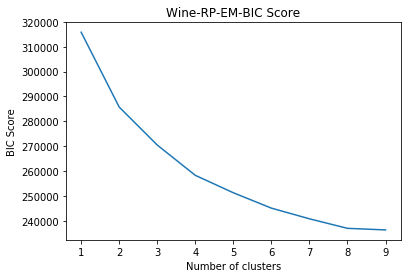

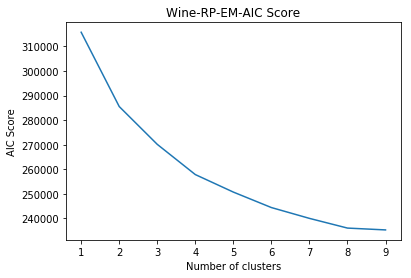

In [285]:
# RP Wine
wine_kmeans_rp = KMeansTestCluster("Wine-RP", rpWX, white_Y, clusters=range(1,10), plot=True, stats=True)
homo_kmeansW.append(wine_kmeans_rp.run())

wine_em_rp = ExpectationMaximizationTestCluster("Wine-RP", rpWX, white_Y, clusters=range(1,10), plot=True, stats=True)
homo_emW.append(wine_em_rp.run())

###
872.9104227900485
###
448.5973877821185
###
331.94908648972273
###
248.9052761891634
###
197.6160612452176
###
164.76933899132032
(5665, 7)
###
143.4608056993571
###
130.0600763781185
###
120.43416800369613
[872.9104227900484, 448.5973877821186, 331.9490864897227, 248.90527618916377, 197.6160612452176, 164.76933899132027, 143.46080569935725, 130.06007637811854, 120.43416800369613]


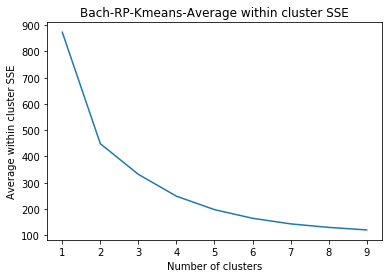

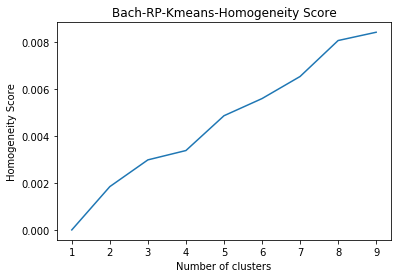

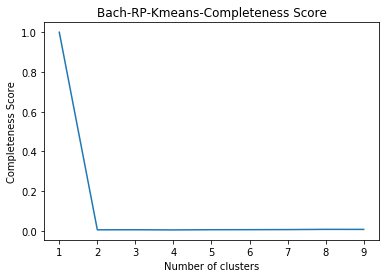

-28.810354197260818
-26.693153676321035
2448
963
2254
-25.606993107249124
-24.79106047221077
-24.134817203139097
-23.714369357122635
-23.31725619543487
-23.084287234496564
-22.841641285696507


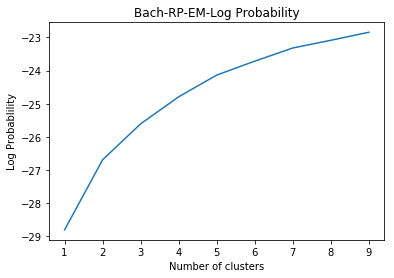

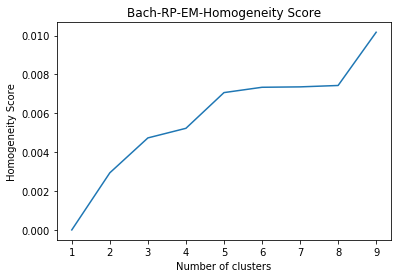

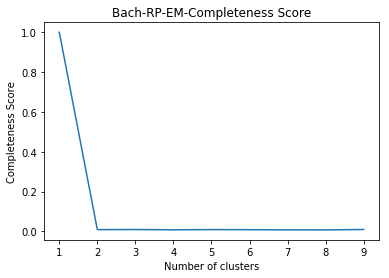

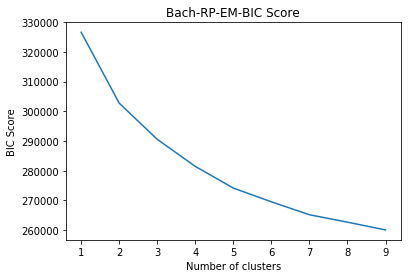

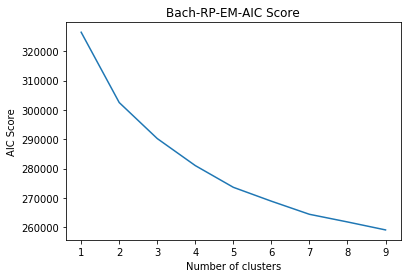

In [286]:
# Bach RP
bach_kmeans_rp = KMeansTestCluster("Bach-RP", rpBX, bach_Y, clusters=range(1,10), plot=True, stats=True)
homo_kmeansB.append(bach_kmeans_rp.run())

bach_em_rp = ExpectationMaximizationTestCluster("Bach-RP", rpBX, bach_Y, clusters=range(1,10), plot=True, stats=True)
homo_emB.append(bach_em_rp.run())

In [287]:
# SVD Data
svdW = TruncatedSVD(n_components=5)
svdWX = svdW.fit_transform(white_X)
svdB = TruncatedSVD(n_components=5)
svdBX = svdB.fit_transform(bach_X)

###
2122.796754967955
###
850.4685951840236
###
560.3089193403579
###
424.7836120332587
###
357.05723270468945
###
315.26659721332555
(4898, 7)
###
280.73837612282847
###
256.7034628329516
###
234.11231951501503
[2122.7967549679543, 850.4685951840239, 560.3089193403571, 424.78361203325716, 357.05723270468985, 315.2665972133267, 280.7383761228291, 256.70346283295044, 234.11231951501523]


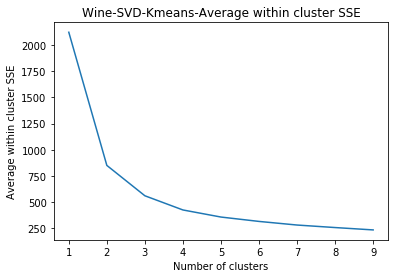

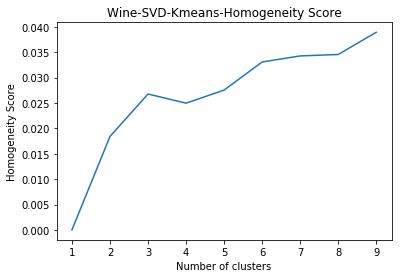

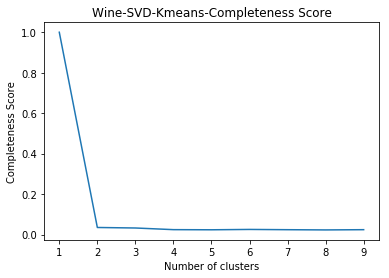

-16.29048288128
-15.834683779147609
1700
1126
2072
-15.656490557104041
-15.538220952606688
-15.295098913349204
-15.185780998101622
-15.06532700910041
-14.985104603290367
-14.950802660907893


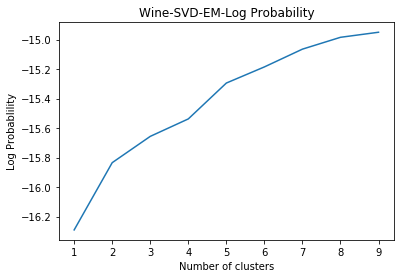

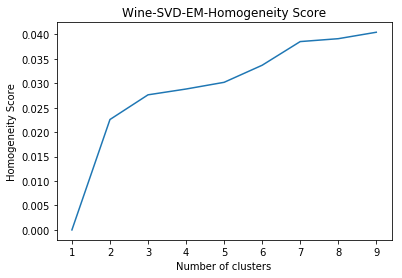

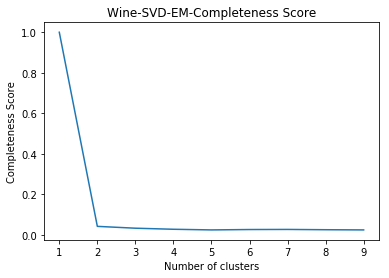

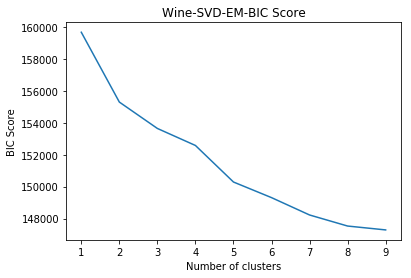

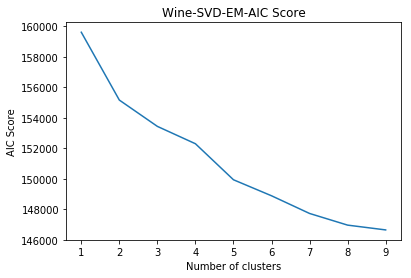

In [302]:
# Wine SVD
wine_kmeans_svd = KMeansTestCluster("Wine-SVD", svdWX, white_Y, clusters=range(1,10), plot=True, stats=True)
homo_kmeansW.append(wine_kmeans_svd.run())

wine_em_svd = ExpectationMaximizationTestCluster("Wine-SVD", svdWX, white_Y, clusters=range(1,10), plot=True, stats=True)
homo_emW.append(wine_em_svd.run())

###
1696.0080593932998
###
789.6671650739358
###
538.9772153832865
###
421.9816612002835
###
339.51565461850464
###
271.37532065746467
(5665, 7)
###
234.93659270407915
###
206.29762950391589
###
187.87214181093378
[1696.0080593932996, 789.6671650739355, 538.9772153832866, 421.9816612002835, 339.5156546185043, 271.3753206574646, 234.93659270407923, 206.29762950391606, 187.87214181093393]


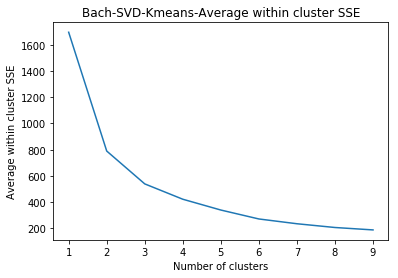

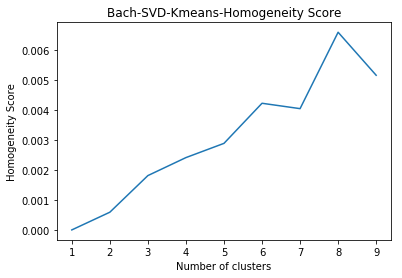

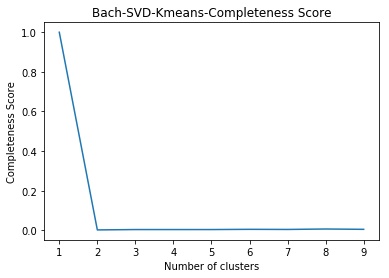

-15.375348194398432
-15.114072639981895
2417
2688
560
-14.994275016857818
-14.890832381699349
-14.874641039079936
-14.792072806658195
-14.766480445194565
-14.752001748573107
-14.73710433800849


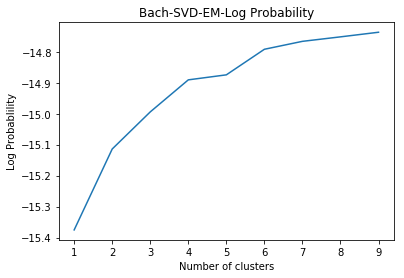

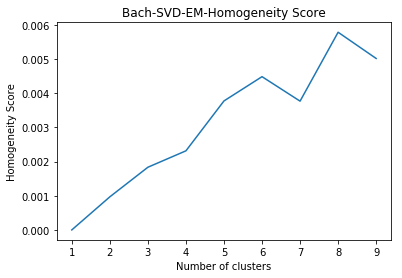

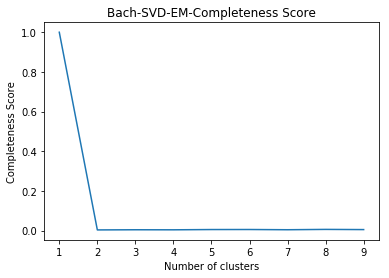

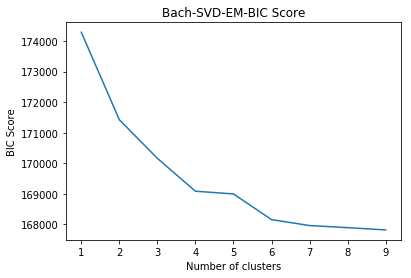

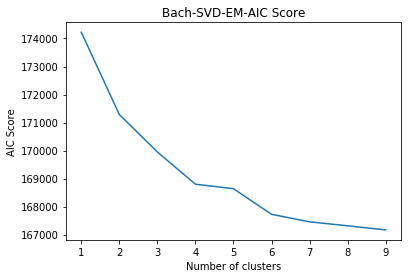

In [289]:
# Bach SVD
bach_kmeans_svd = KMeansTestCluster("Bach-SVD", svdBX, bach_Y, clusters=range(1,10), plot=True, stats=True)
homo_kmeansB.append(bach_kmeans_svd.run())

bach_em_rp = ExpectationMaximizationTestCluster("Bach-SVD", svdBX, bach_Y, clusters=range(1,10), plot=True, stats=True)
homo_emB.append(bach_em_rp.run())

<module 'matplotlib.pyplot' from '/home/ivyivylynn/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

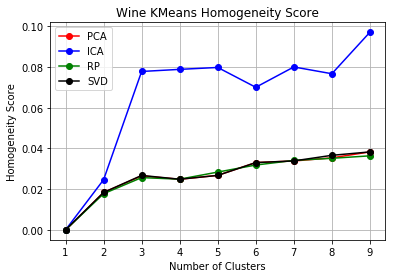

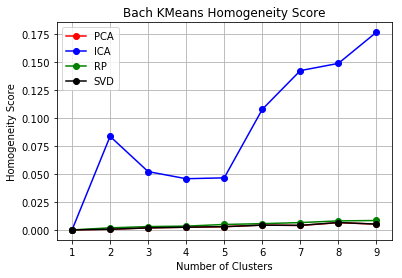

In [300]:
plot_mult_line(range(1, 10), homo_kmeansW, homo_labels , "Wine KMeans Homogeneity Score","Number of Clusters", "Homogeneity Score")
plot_mult_line(range(1, 10), homo_kmeansB, homo_labels , "Bach KMeans Homogeneity Score","Number of Clusters", "Homogeneity Score")

<module 'matplotlib.pyplot' from '/home/ivyivylynn/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

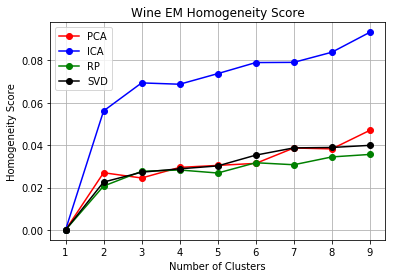

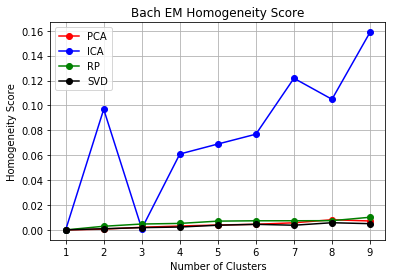

In [301]:
plot_mult_line(range(1, 10), homo_emW, homo_labels , "Wine EM Homogeneity Score","Number of Clusters", "Homogeneity Score")
plot_mult_line(range(1, 10), homo_emB, homo_labels , "Bach EM Homogeneity Score","Number of Clusters", "Homogeneity Score")

# Neural Network With Feature Reduction(Wine)

In [290]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import validation_curve

In [291]:
def Evaluate_clf(name, clf, params, X, Y, scorer=make_scorer(accuracy_score), plot=False, njobs=4, contour=False):
    print("Evaluating " + name)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    cv_clf = GridSearchCV(clf, param_grid=params, refit=True, cv=3, scoring=scorer , n_jobs=njobs, return_train_score=True)
    
    start = timeit.default_timer()
    cv_clf.fit(x_train, y_train)
    end = timeit.default_timer()
    # plot contour
    if contour :
        plot_contour2d(cv_clf, params, 'max_depth', 'min_samples_leaf')
    
    train_time = end - start
    train_score = cv_clf.score(x_train, y_train)
    cv_estimator = cv_clf.best_estimator_
    
    print("Train time: " + str(train_time))
    print("Train score: " + str(train_score * 100) + "%")
    print("Best params: " + str(cv_clf.best_params_))
    
    # start testing
    start = timeit.default_timer()
    test_score = cv_clf.score(x_test, y_test)
    end = timeit.default_timer()
    test_time = end - start
    print('Test time: ' + str(test_time))
    print('Test score: ' + str(test_score * 100) + "%")
    print('Diff Train - Test in % : ' + str((train_score - test_score) * 100) + "%") 
    
    # learning curve
    cv_curve = learning_curve(cv_estimator, x_train, y_train, train_sizes=np.linspace(0.1, 1, 10), n_jobs=4)
    plot_learning_curve(name, cv_curve)
    
    return (cv_estimator, cv_clf)

def plot_score_iteration(estimator, name):
    plt.grid()
    plt.title(name)
    plt.plot(estimator.validation_scores_, 'o-', color="r")
    plt.xlabel("Number of Iteration")
    plt.ylabel("Score")
    plt.show()

In [292]:
# input x, y return score over iteration and print training time
def nn_FR(x, y):
    mlp = MLPClassifier(activation='logistic', solver='adam', early_stopping=True, validation_fraction=0.2, random_state=7, batch_size='auto')
    mlp.fit(x, y)
    return mlp.validation_scores_
    
    

In [293]:
def plot_mult_diff(ys, legends, title, xLabel, yLabel):
    plt.figure()
    plt.title(title)

    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    
    plt.grid()

    colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y']
    for i in range(len(ys)):
        val = ys[i]
        label = legends[i]
        color = colors[i]

        plt.plot(range(len(val)), val, 'o-', color=color,
             label=label)

    plt.legend(loc="best")

In [294]:
mlp_labels = ["Oiginal" , "PCA", "ICA", "RP", "SVD"]
mlp_results = []
mlp_results.append(nn_FR(white_X, white_Y))
mlp_results.append(nn_FR(wine_pcaX, white_Y))
mlp_results.append(nn_FR(icaWX, white_Y))
mlp_results.append(nn_FR(rpWX, white_Y))
mlp_results.append(nn_FR(svdWX, white_Y))

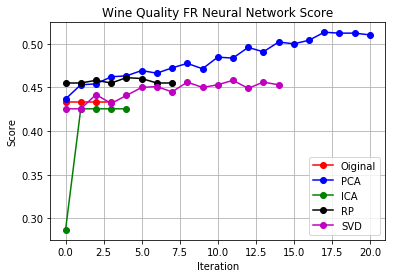

In [295]:
plot_mult_diff(mlp_results, mlp_labels, "Wine Quality FR Neural Network Score", "Iteration", "Score")

# Neural Network with Clustering as Feature

In [296]:
def make_array(clustering, X, n_components):
    size = len(X)
    clustering.fit(X)
    new_X = np.zeros((size, n_components + 1))
    new_X[:, 0:n_components] = X
    new_X[:, n_components] = clustering.predict(X)

    return new_X



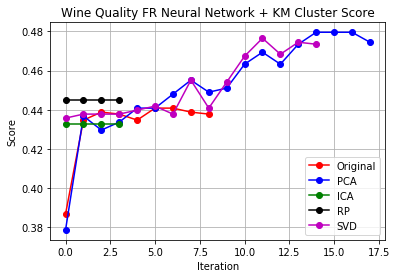

In [297]:
# Kmeans cluster 
km = KMeans(n_clusters=7)
km_labels = ["Original", "PCA", "ICA", "RP", "SVD"]
km_inputs = []
km_scores = []
km_inputs.append(make_array(km, white_X, 11))
km_inputs.append(make_array(km, wine_pcaX, 4))
km_inputs.append(make_array(km, icaWX, 5))
km_inputs.append(make_array(km, rpWX, 8))
km_inputs.append(make_array(km, svdWX, 5))
for kminput in km_inputs:
    km_scores.append(nn_FR(kminput, white_Y))
    
plot_mult_diff(km_scores, km_labels, "Wine Quality FR Neural Network + KM Cluster Score", "Iteration", "Score")

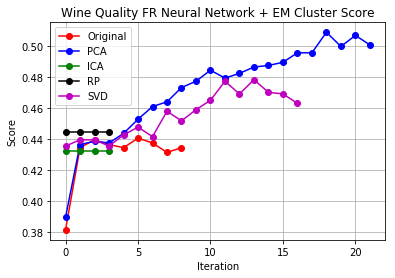

In [298]:
# EM cluster 
em = GMM(n_components=7)
em_labels = ["Original", "PCA", "ICA", "RP", "SVD"]
em_inputs = []
em_scores = []
em_inputs.append(make_array(em, white_X, 11))
em_inputs.append(make_array(em, wine_pcaX, 4))
em_inputs.append(make_array(em, icaWX, 5))
em_inputs.append(make_array(em, rpWX, 8))
em_inputs.append(make_array(em, svdWX, 5))
for eminput in em_inputs:
    em_scores.append(nn_FR(eminput, white_Y))
    
plot_mult_diff(em_scores, em_labels, "Wine Quality FR Neural Network + EM Cluster Score", "Iteration", "Score")